# ViT

This notebook is used to perform experiments using ViT model, reported in the paper. <br>
It was run using Google Colab during the experiments.

In [1]:
import sys

# uncomment when running on Google Colab
# from google.colab import drive
# path_on_google_drive = ""  # path to your gdrive

# drive.mount("/content/gdrive")
# root_path = f"/content/gdrive/My Drive/{path_on_google_drive}"

# uncomment when running locally
# root_path = ".."  # top-level of the repository

sys.path.append(root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install transformers -q  # running on colab requires this step

In [3]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline
from skimage import io
from transformers import ViTFeatureExtractor, ViTModel
from tqdm import tqdm

from src.metrics import regression_report, regression_score
from src.utils import load_image_batch

In [4]:
plt.rcParams["figure.figsize"] = (16, 10)

# Dataset

In [5]:
mesurements_df = pd.read_csv(os.path.join(root_path, "data/dataset.csv"))
mesurements_df.head(3)

,Sample,Hardness,File,Location,Code
0,1-101-2,129.9,../data/images/processed/1-101-2.jpg,top-right,1-101
1,1-101-4,130.0,../data/images/processed/1-101-4.jpg,bottom-left,1-101
2,1-102-2,137.6,../data/images/processed/1-102-2.jpg,top-right,1-102


Change paths to match Colab directory structure

In [6]:
def path_without_first_dir(path):
    """Remove .. from paths"""
    return "/".join(path.split(r"/")[1:])

mesurements_df["File"] = mesurements_df["File"].apply(lambda path: os.path.join(root_path, path_without_first_dir(path)))

Split dataset into train and test using sample code, to prevent information leakage.

In [7]:
train_codes, test_codes = train_test_split(mesurements_df["Code"].unique(), test_size=0.3, random_state=7)
len(train_codes), len(test_codes)

(176, 76)

In [8]:
train_df = mesurements_df.loc[mesurements_df["Code"].isin(train_codes)]
test_df = mesurements_df.loc[mesurements_df["Code"].isin(test_codes)]

train_images = load_image_batch(train_df["File"].tolist())
test_images = load_image_batch(test_df["File"].tolist())

In [9]:
train_codes, test_codes = train_test_split(mesurements_df["Code"].unique(), test_size=0.3, random_state=7)
len(train_codes), len(test_codes)

(176, 76)

# Feature Extractor

Load and check `ViTFeatureExtractor`

In [10]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

In [11]:
index = np.random.randint(len(train_images))

inputs = feature_extractor(images=train_images[index], return_tensors="pt")
type(inputs)

transformers.feature_extraction_utils.BatchFeature

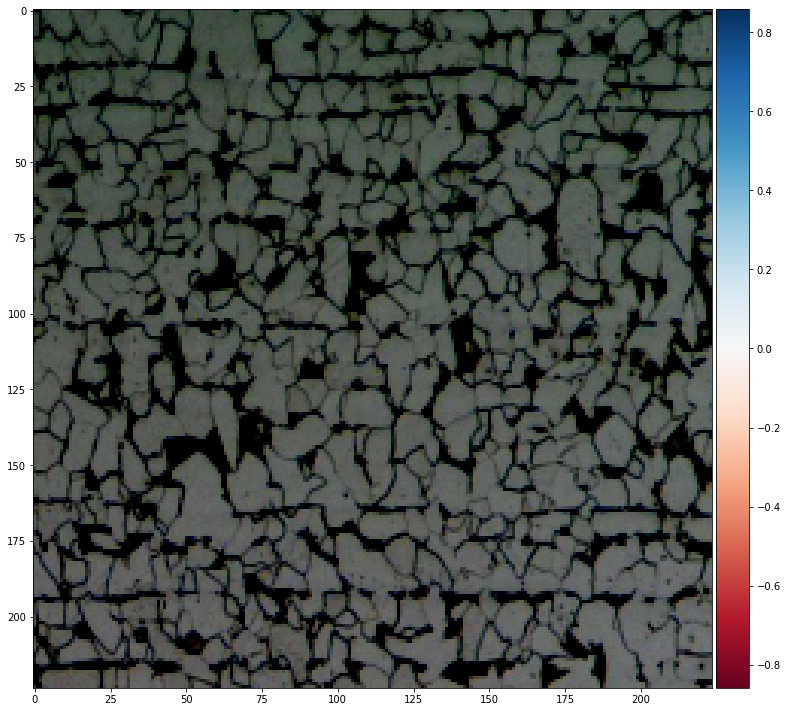

In [12]:
# display image transformed by ViTFeatureExtractor
_ = io.imshow(inputs["pixel_values"][0].permute(1,2,0).numpy())

# Model

Load ViT model from HuggingFace hub. <br>
More details can be found in the [docs](https://huggingface.co/docs/transformers/model_doc/vit) and [model card](https://huggingface.co/google/vit-base-patch16-224).

In [13]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224")
type(model)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


transformers.models.vit.modeling_vit.ViTModel

In [14]:
# run a model on single image
with torch.no_grad():
    outputs = model(inputs["pixel_values"])

type(outputs)

transformers.modeling_outputs.BaseModelOutputWithPooling

In [15]:
outputs["pooler_output"].shape

torch.Size([1, 768])

# Image Embeddings

Compute image embeddings for all dataset and store them for later usage. This is done on training and test dataset, but model simply is used as feature extractor, so there is no information leakage.

In [16]:
for file_name in tqdm(mesurements_df["File"].tolist()):
    file_name = file_name.split("/")[-1]
    image = io.imread(os.path.join(root_path, f"data/images/processed/{file_name}"))
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(inputs["pixel_values"])

    torch.save(outputs["pooler_output"][0], os.path.join(root_path, f"data/images/tensors/{file_name}.pt"))

In [17]:
# load train and test features from pre-computed embeddings
train_features = []
test_features = []

for file in train_df["File"]:
    train_features.append(torch.load(os.path.join(root_path, f"data/images/tensors/{os.path.basename(file)}.pt")))

for file in test_df["File"]:
    test_features.append(torch.load(os.path.join(root_path, f"data/images/tensors/{os.path.basename(file)}.pt")))


train_features = torch.stack(train_features, dim=0)
test_features = torch.stack(test_features, dim=0)

# Prepare Features

Prepare image embeddings and targets before training the downstream model.

In [18]:
# transform targets using standard scaler
target_pipeline = Pipeline([
    ("scalar", StandardScaler()),
])

targets = target_pipeline.fit_transform(train_df["Hardness"].values.reshape(-1, 1))

In [19]:
# transform features using PowerTransformer
feature_pipeline = Pipeline([
    ("scalar", StandardScaler()),
    ("transform", PowerTransformer())
])

# transform feature using sklearn pipeline
train_features = feature_pipeline.fit_transform(train_features.numpy())
test_features = feature_pipeline.transform(test_features.numpy())
# convert back to torch tensors
train_features = torch.from_numpy(train_features)
test_features = torch.from_numpy(test_features)
# create torch DataLoaders for train and test sets
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features, torch.from_numpy(targets)), shuffle=True, batch_size=16)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_features, torch.from_numpy(test_df["Hardness"].values)), batch_size=16, shuffle=False)

# Downstream Model

Prepare a simple feedfoward network as a downstream model to learn mapping from embeddings to measured hardness values. 

In [20]:
class ViTRegressor(torch.nn.Module):
    def __init__(self):
        super().__init__()    

        self.network = torch.nn.Sequential(
            torch.nn.Linear(in_features=768, out_features=40),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=40, out_features=1),
        )
    
    def forward(self, inputs):
        return self.network(inputs)

In [21]:
regressor = ViTRegressor()
# define hyperparameters
epochs = 100
optimizer = torch.optim.Adam(regressor.parameters())
loss = torch.nn.MSELoss()

Train the model using simple training loop

In [22]:
for epoch in range(epochs):
    regressor.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(torch.float32), y.to(torch.float32)

        optimizer.zero_grad()
        y_pred = regressor(x)

        mse = loss(y, y_pred)
        mse.backward()
        optimizer.step()

        # print statistics
        running_loss += mse.item()

    # log loss
    if epoch % 10 == 0:
        print(f"Loss at epoch {epoch} = {running_loss:.8f}")

Loss at epoch 0 = 33.62197673
Loss at epoch 10 = 8.73517619
Loss at epoch 20 = 3.96070994
Loss at epoch 30 = 3.48118018
Loss at epoch 40 = 2.33607592
Loss at epoch 50 = 2.16733359
Loss at epoch 60 = 2.27346045
Loss at epoch 70 = 1.91796264
Loss at epoch 80 = 1.72888357
Loss at epoch 90 = 1.77416292


In [23]:
predictions = []

for x, y in test_loader:
    x = x.to(torch.float32)
    y_pred = regressor(x)
    predictions.append(y_pred.cpu().detach().numpy())
    
predictions = np.concatenate(predictions)
predictions = target_pipeline.inverse_transform(predictions)
predictions.shape

(256, 1)

In [24]:
# report number of parameters of trained model
sum(p.numel() for p in regressor.parameters() if p.requires_grad)

30801

Results might vary from run to run, since the downstream model is prone to changes in initialization. <br>
However it does not perform better then other methods reported in the paper. 

In [25]:
print(regression_report(y_true=test_df["Hardness"].values, y_pred=predictions.flatten()))

                                Absolute                        Normalized                      

Mean Squared Error:             53.3406                         6.5928                          
Root Mean Squared Error:        7.3035                          0.9027                          
Mean Absolute Error:            5.8449                          0.7224                          
Median Absolute Error:          4.8762                          0.6027                          
Max Error:                      21.1386                         2.6127                          
R2                                                              0.1851                          


                                True                            Predicted                       

Mean:                           136.9574                        137.5162                        
std:                            8.0907                          5.7162                          

